## Chuẩn bị

In [ ]:
%%capture
!pip install ultralytics
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from ultralytics import YOLO

In [ ]:
device = torch.device("cuda")

In [ ]:
np.random.seed(3)

def show_mask(mask, ax, random_color=True, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=50):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
iname = "/content/drive/MyDrive/Spinacia/images/val/1.X5.1.883.jpg"

In [ ]:
image = cv2.imread(iname)

In [ ]:
image.shape

(4032, 2268, 3)

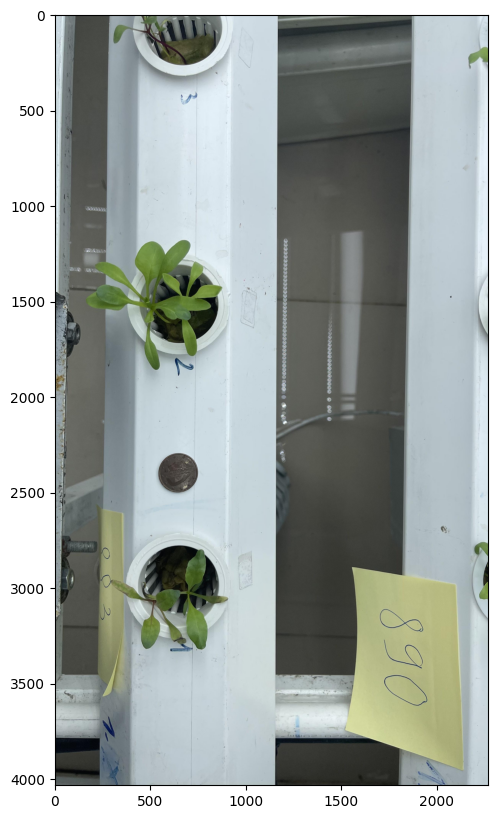

In [ ]:
plt.imshow(image[:,:,::-1])
plt.show()

## Các hàm
check_green : lọc màu xanh

sam2_input : tạo prompt từ box kết quả yolo2 và điểm tâm box

find_crop : tách crop từ kết quả yolo1

check_mask : kiểm tra màu xanh của mask

clean_mask : xử lý các mask chồng nhau

mask_full : chuyển tọa độ mask về ảnh gốc



In [ ]:
def check_green(image,min_green = np.array([35,25,25]),max_green = np.array([70,255,255])) :
    # Chuyển ảnh sang HSV
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # Tạo mask từ ngưỡng
    mask = cv2.inRange(hsv, min_green, max_green)

    # Xóa nhiễu và làm mịn
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    return mask

In [ ]:
def sam2_input(results,green):
    if len(results) == 0 or len(results[0].boxes) == 0:
        return None, None, None

    # Lấy box
    boxes = results[0].boxes.xyxy.cpu().numpy()

    # Tính tâm các box
    center_x = (boxes[:, 0] + boxes[:, 2]) / 2
    center_y = (boxes[:, 1] + boxes[:, 3]) / 2
    centers = np.stack([center_x, center_y], axis=1)

    # point và label prompt
    points = centers[:, np.newaxis, :]
    # Lấy giá trị pixel tại các điểm tâm
    h, w = image.shape[:2]
    cx = np.clip(center_x.astype(int), 0, w)
    cy = np.clip(center_y.astype(int), 0, h)

    is_positive = green[cy, cx] > 0
    labels = is_positive.astype(np.float32)[:, np.newaxis]

    return boxes, points, labels

In [ ]:
def check_mask(green, s_mask, min_green_ratio=0.3):
    s_mask = np.squeeze(s_mask)
    s_mask = (s_mask > 0).astype(np.uint8) * 255
    # Vùng xanh của mask
    overlap = cv2.bitwise_and(green, green, mask=s_mask)

    # Diện tích mask và vùng xanh
    area_mask = cv2.countNonZero(s_mask)
    if area_mask == 0 : return False
    green_area = cv2.countNonZero(overlap)

    # Tỉ lệ vùng xanh
    ratio = green_area / area_mask
    #print(ratio)
    # Lọc theo tỉ lệ và diện tích
    return ratio >= min_green_ratio

In [ ]:
def clean_mask(masks, scores,thresh=0.5):
    scores = scores.flatten()
    if masks.ndim == 4:
        masks = masks.squeeze(1)

    # sắp xếp  theo scores
    sorted_indices = np.argsort(scores)[::-1]
    h, w = masks[0].shape[:2]
    occupied_region = np.zeros((h, w), dtype=bool)

    final_masks = []
    final_indices = []

    # Những vùng trùng sẽ tính theo mask score cao hơn
    for idx in sorted_indices:
        current_mask = masks[idx].astype(bool)
        current_area = np.count_nonzero(current_mask)
        cleaned_mask = current_mask & (~occupied_region)
        cleaned_area = np.count_nonzero(cleaned_mask)
        ratio = cleaned_area / current_area

        if ratio > thresh:
            mask_final = cleaned_mask.astype(np.uint8)
            final_masks.append(mask_final)
            final_indices.append(idx)
            occupied_region = occupied_region | cleaned_mask

    return final_masks, final_indices

In [ ]:
def find_crop(image,results) :
    boxes = results[0].boxes.xyxy

    box_results = []
    crops = []
    positions = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        box_results.append(box)

    for i in box_results :
        x1,y1,x2,y2 = i.int().tolist()
        crop = image[y1:y2, x1:x2].copy()
        crops.append(crop)
        positions.append((y1,y2,x1,x2))
    return crops,positions

In [ ]:
def mask_full(mask,h,w,position) :
    mask_f = np.zeros((h, w), dtype=np.uint8)
    y1, y2, x1, x2 = position
    mask_f[y1:y2, x1:x2] = mask
    return mask_f

## Quy trình

B1 : Ảnh -> yolo1 -> crop

B2 : crop -> yolo2 -> box

B3 : prompt = box + point(tâm box) -> SAM2 -> masks

B4 : masks -> check_mask -> clean_mask -> new_masks

B5 : new_masks -> mask_full -> mask_all -> kết quả

In [ ]:
image_pil = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [ ]:
model = YOLO("/content/drive/MyDrive/Spinacia/best.pt")

In [ ]:
results = model.predict(image_pil, save=False)


0: 1280x736 5 Spinacias, 16.1ms
Speed: 12.7ms preprocess, 16.1ms inference, 2.4ms postprocess per image at shape (1, 3, 1280, 736)


In [ ]:
crops,positions = find_crop(image_pil,results)
n = len(crops)
n

5

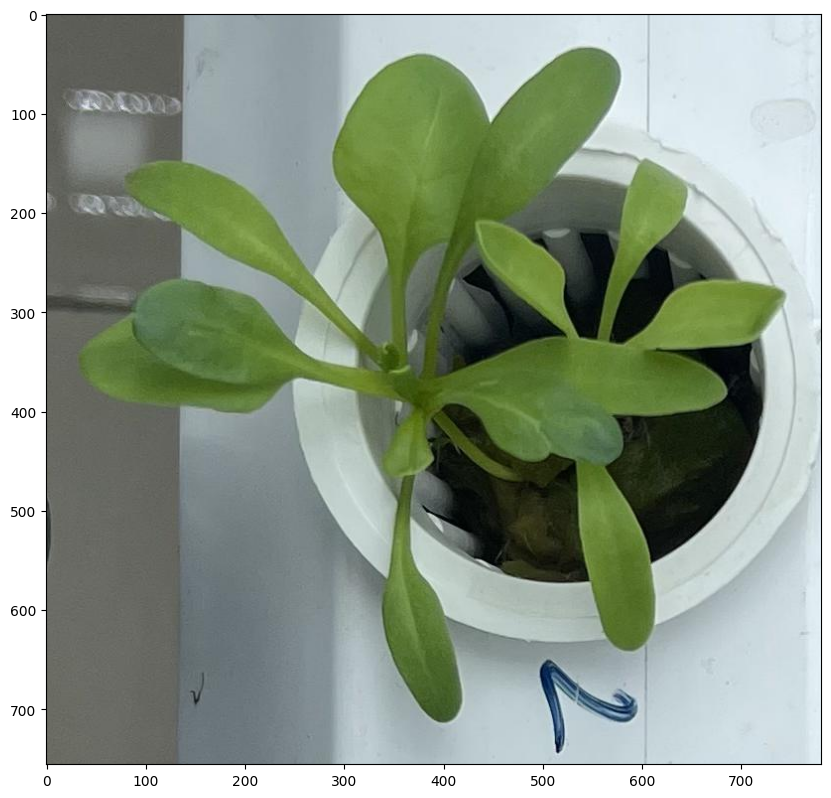

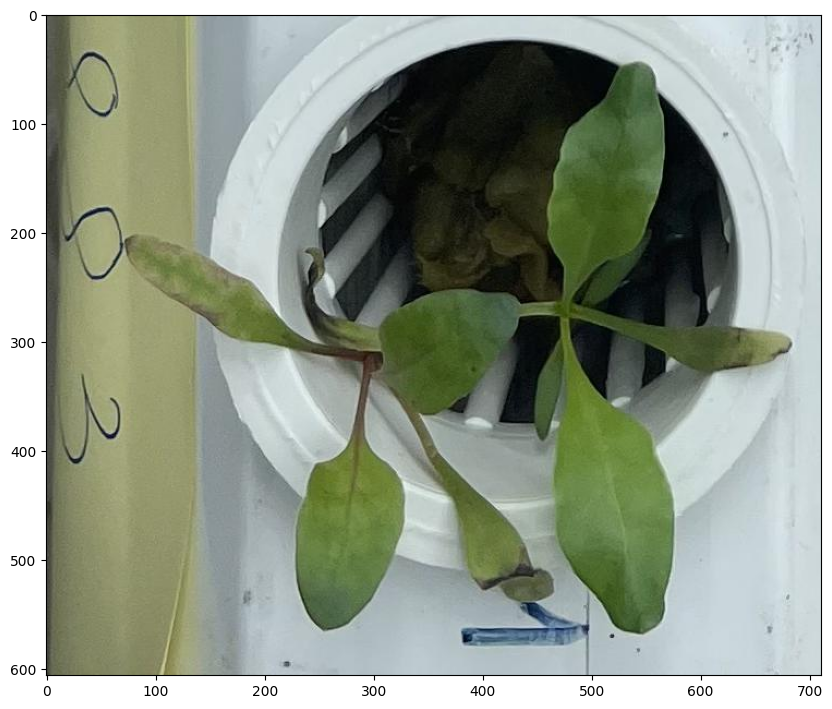

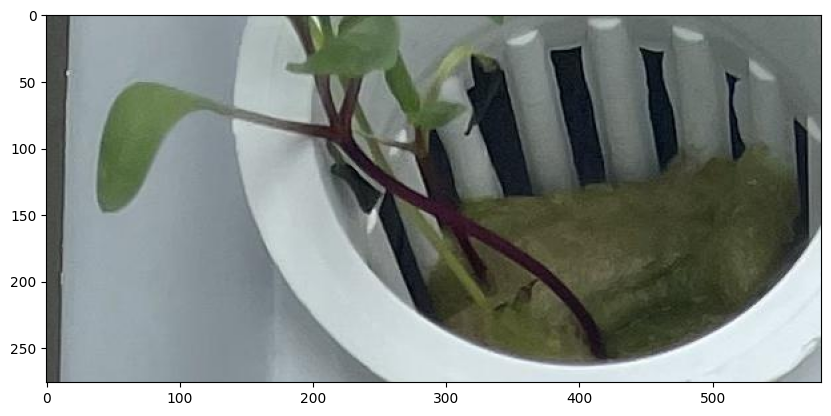

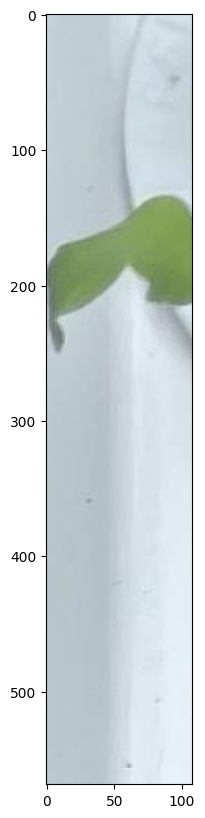

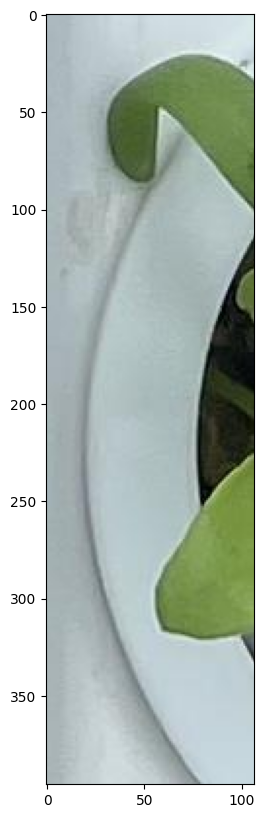

In [ ]:
for i in range(0,n):
    plt.figure(figsize=(10, 10))
    plt.imshow(crops[i])
    plt.show()

In [ ]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/content/drive/MyDrive/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
model2 = YOLO("/content/drive/MyDrive/Data_leaf/best.pt")

### Mask mỗi crop


0: 640x640 18 Spinacias, 10.2ms
Speed: 3.3ms preprocess, 10.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


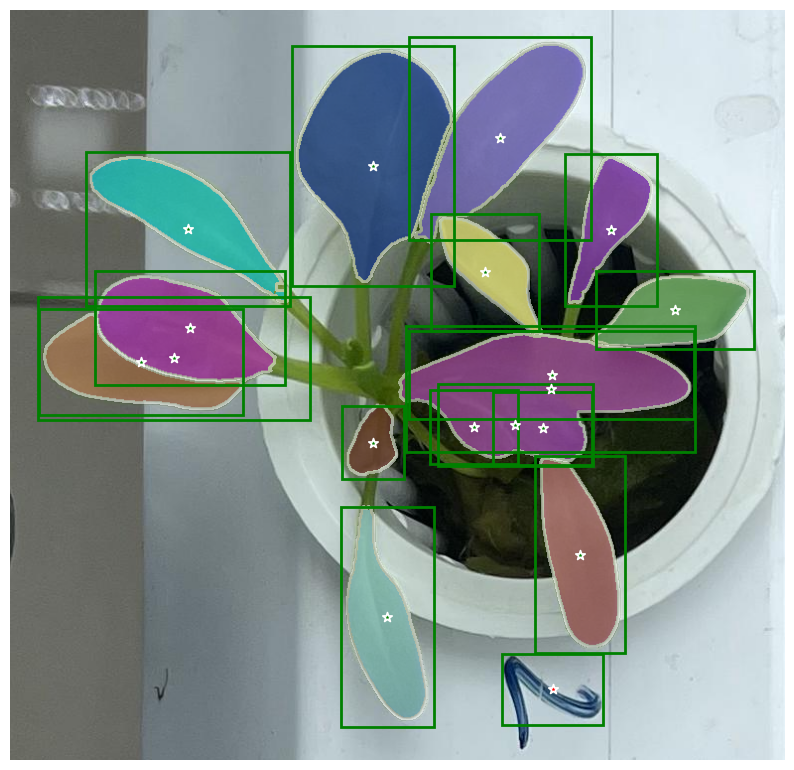


0: 576x640 13 Spinacias, 15.9ms
Speed: 3.6ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)


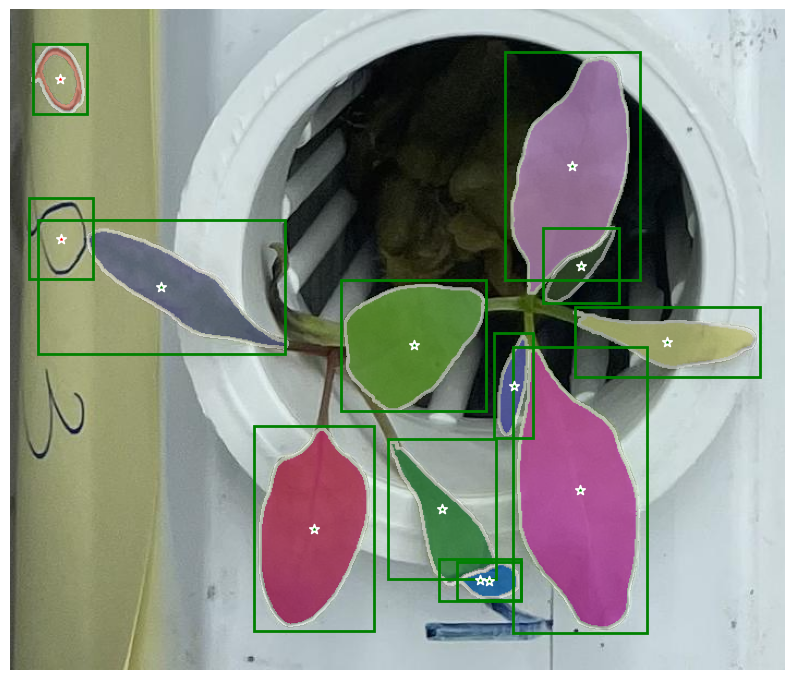


0: 320x640 4 Spinacias, 12.8ms
Speed: 2.2ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


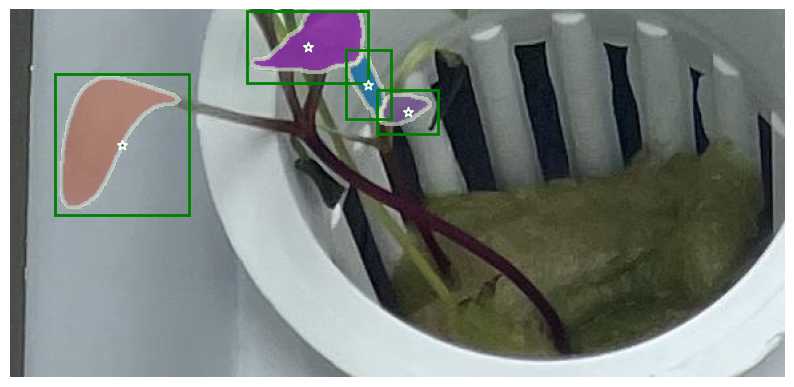


0: 640x128 1 Spinacia, 13.7ms
Speed: 1.1ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 128)


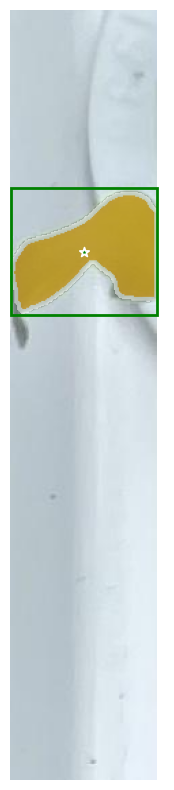


0: 640x192 3 Spinacias, 21.2ms
Speed: 1.4ms preprocess, 21.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)


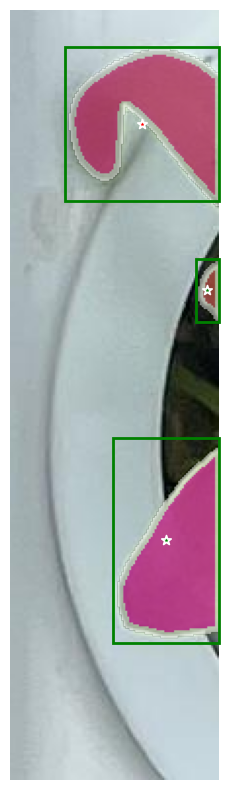

In [ ]:
for i in range(n):
    results2 = model2.predict(crops[i], save=False)
    predictor.set_image(crops[i])
    green = check_green(crops[i])

    boxes, points, labels = sam2_input(results2,green)
    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=labels,
        box=boxes,
        multimask_output=False,
    )

    plt.imshow(crops[i])
    new_masks, index = clean_mask(masks, scores)
    for mask in new_masks:
        if (check_mask(green,mask) == 0) : continue
        show_mask(mask, plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())
    show_points(points, labels, plt.gca())
    plt.axis('off')
    plt.show()

### Mask toàn ảnh

In [ ]:
h,w = image.shape[:2]

In [ ]:
n = len(crops)
mask_all = []
for i in range(n) :
    image_display = crops[i].copy()
    predictor.set_image(crops[i])
    crop = crops[i]
    results2 = model2.predict(crop, save=False)
    green = check_green(crops[i])
    boxes, points, labels = sam2_input(results2,green)
    masks, scores, _ = predictor.predict(
        point_coords=points,
        point_labels=labels,
        box=boxes,
        multimask_output=False,
    )
    new_masks, index = clean_mask(masks, scores)

    for mask in new_masks :
        if (check_mask(green,mask) == False) : continue
        mask = mask_full(mask,h,w,positions[i])
        mask_all.append(mask)


0: 640x640 18 Spinacias, 18.4ms
Speed: 3.1ms preprocess, 18.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/predict4

0: 576x640 13 Spinacias, 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)
Results saved to /content/runs/detect/predict4

0: 320x640 4 Spinacias, 11.7ms
Speed: 2.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)
Results saved to /content/runs/detect/predict4

0: 640x128 1 Spinacia, 12.9ms
Speed: 1.4ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 128)
Results saved to /content/runs/detect/predict4

0: 640x192 3 Spinacias, 14.4ms
Speed: 1.7ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 192)
Results saved to /content/runs/detect/predict4


In [ ]:
len(mask_all)

31

In [ ]:
image_display = image_pil.copy()

In [ ]:
for i in mask_all :
    color = np.random.randint(0, 256, size=(3,), dtype=np.uint8)
    image_display[i > 0] = color

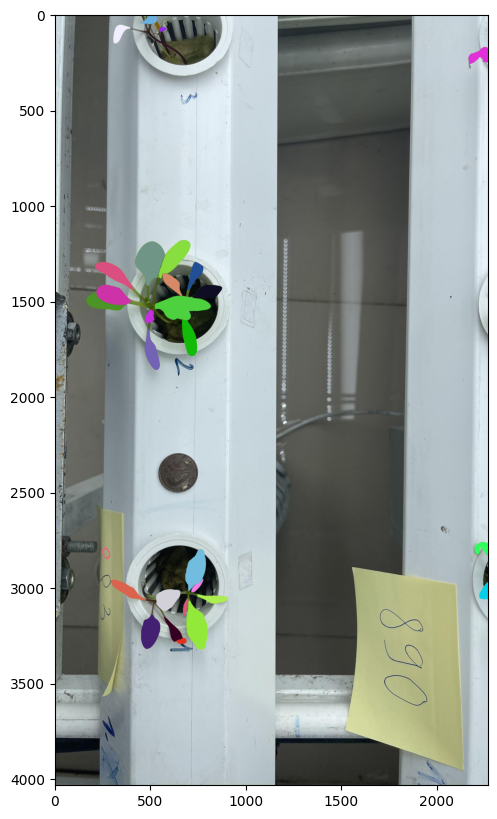

In [ ]:
plt.imshow(image_display)
plt.show()